In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pint

ureg = pint.UnitRegistry()
ureg.setup_matplotlib()
ureg.define("neutron = 1 * particle = n")

SPECIFIC_ACT = 3.57e14 * ureg.Bq * ureg.g**-1
MOLAR_MASS = 6.032 / 2 * ureg.g * ureg.mol**-1


## Model definition

$$ V \frac{d c_\mathrm{salt}}{dt} = S - Q_\mathrm{wall} - Q_\mathrm{top} $$

$$ S = \mathrm{TBR} \cdot \Gamma_n $$
where $\Gamma_n$ is the neutron rate in n/s.
$\mathrm{TBR}$ is assumed to evolve proportionally to the radius (see Figure 7 of [LIBRA paper](https://www.tandfonline.com/doi/full/10.1080/15361055.2022.2078136)) with $ \mathrm{TBR}(r= 7 \mathrm{cm}) = 0.01 $.

$Q_i$ are the release rate of T permeating through the walls and being released at the top of the salt and are expressed as:
$$ Q_i = A_i \ k_i \ (c_\mathrm{salt} - c_\mathrm{external}) \approx A_i \ k_i \ c_\mathrm{salt}$$
where $A_i$ is the contact surface area, $k_i$ are the mass transfer coefficients.

**Note**: this assumes the wall resistance to mass transfer is negligible. This assumption will be discussed below.

In [2]:
# BABY standard geometry
volume = 1 * ureg.L
radius = 7 * ureg.cm
cross_section = np.pi * radius**2
height = volume / cross_section
HEIGHT_TO_RADIUS = height / radius

class Model:
    def __init__(self) -> None:
        self.radius = 7 * ureg.cm

        self.L_wall = 1 * ureg.cm  # TODO: VERIFY THIS

        self.neutron_rate = 3e8 * ureg.neutron * ureg.s**-1

        self.c_old = 0 * ureg.particle * ureg.m**-3
        self.dt = 1 * ureg.h
        self.exposure_time = 300 * ureg.h

        self.concentrations = []
        self.times = []

    @property
    def volume(self):
        return self.A_top * self.height

    @property
    def height(self):
        return HEIGHT_TO_RADIUS * self.radius

    @property
    def A_top(self):
        return np.pi * self.radius**2

    @property
    def A_wall(self):
        perimeter_wall = 2 * np.pi * (self.radius + self.L_wall)
        return perimeter_wall * self.height

    @property
    def TBR(self):
        ratio = 0.01 * ureg.particle * ureg.neutron**-1 / (7 * ureg.cm)
        return ratio * self.radius

    def source(self, t):
        if t < self.exposure_time:
            return self.TBR * self.neutron_rate
        else:
            return 0 * self.TBR * self.neutron_rate

    def Q_wall(self, c_salt):
        k_wall = 1.9e-8 * ureg.m * ureg.s**-1  # from Kumagai
        return self.A_wall * k_wall * c_salt
    

    def Q_top(self, c_salt):
        k_top = 4.9e-7 * ureg.m * ureg.s**-1  # from Kumagai
        return self.A_top * k_top * c_salt

    def equation(self, c, t):
        c *= ureg.particle * ureg.m**-3

        lhs = self.volume * (c - self.c_old) / self.dt
        rhs = self.source(t) - self.Q_wall(c) - self.Q_top(c)
        return lhs - rhs

    def run(self, t_final):
        t = 0 * ureg.s
        while t < t_final:
            t += self.dt
            c_new = (
                fsolve(self.equation, x0=self.c_old, args=(t,))
                * ureg.particle
                * ureg.m**-3
            )
            self.c_old = c_new

            self.times.append(t)
            self.concentrations.append(c_new)
        self.concentrations = ureg.Quantity.from_list(self.concentrations)
        self.times = ureg.Quantity.from_list(self.times)


## Standard BABY run

In [3]:
baby_model = Model()
baby_model.run(baby_model.exposure_time * 2)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


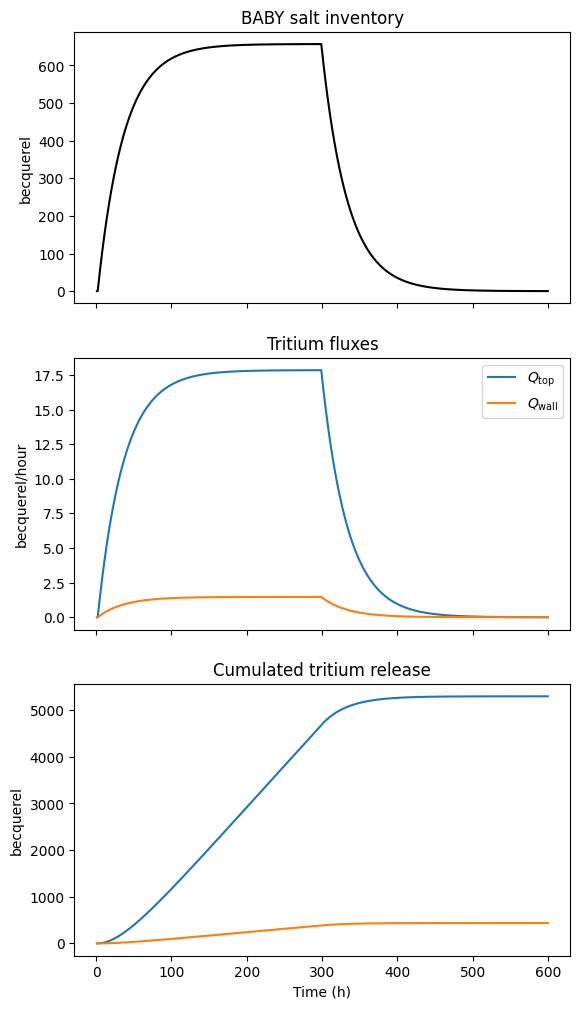

In [4]:
from scipy.integrate import cumulative_trapezoid

time = baby_model.times.to(ureg.h)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("BABY salt inventory")
inventory = baby_model.concentrations * baby_model.volume * SPECIFIC_ACT * MOLAR_MASS
plt.plot(time, inventory.to(ureg.Bq), color="black")

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = baby_model.Q_top(baby_model.concentrations) * SPECIFIC_ACT * MOLAR_MASS
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = (
    baby_model.Q_wall(baby_model.concentrations)
    * SPECIFIC_ACT
    * MOLAR_MASS
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="$Q_\mathrm{top}$")
plt.plot(time, release_walls, label="$Q_\mathrm{wall}$")
plt.legend()

plt.sca(ax_cumul)
plt.title("Cumulated tritium release")
integrated_top = (
    cumulative_trapezoid(
        release_top.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        release_walls.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(time, integrated_top, label="top")
plt.plot(time, integrated_wall, label="wall")
plt.xlabel(f"Time ({time.units:~P})")
plt.show()


## Varying the volume of salt

In [5]:
radius_values = [1, 2, 3, 4, 5, 6, 7] * ureg.cm
models = []

for radius in radius_values:
    my_model = Model()
    my_model.radius = radius
    models.append(my_model)

    my_model.run(my_model.exposure_time * 2)


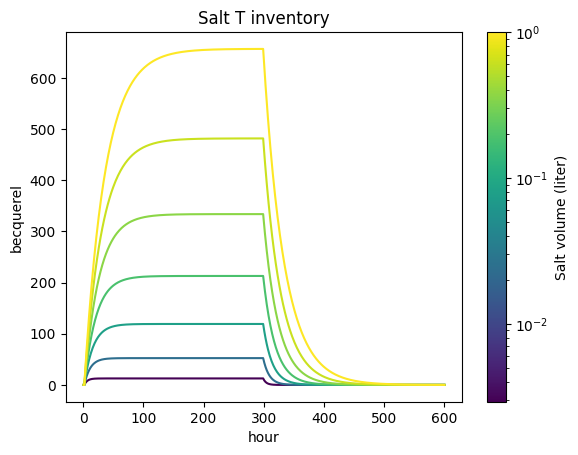

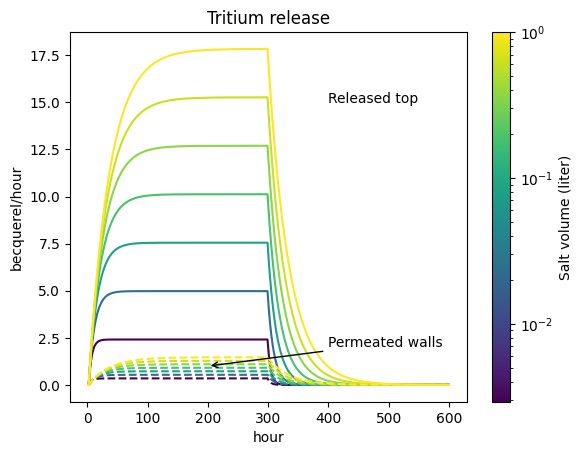

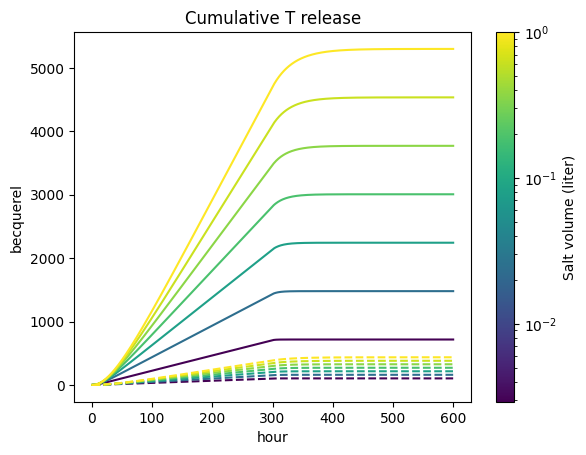

In [6]:
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

volume_values = [model.volume for model in models]
volume_values = ureg.Quantity.from_list(volume_values)
norm_V_salt = LogNorm()
norm_V_salt.autoscale(volume_values.magnitude)


for model in models:
    times = model.times.to(ureg.h)
    colour = cm.viridis(norm_V_salt(model.volume.magnitude))

    # plot inventory
    plt.figure(1)
    inventory = model.volume * model.concentrations * SPECIFIC_ACT * MOLAR_MASS
    plt.plot(times, inventory.to(ureg.Bq), color=colour)

    # plot fluxes
    plt.figure(2)
    top_release = model.Q_top(model.concentrations)
    top_release *= SPECIFIC_ACT * MOLAR_MASS
    top_release = top_release.to(ureg.Bq * ureg.h**-1)
    wall_release = model.Q_wall(model.concentrations)
    wall_release *= SPECIFIC_ACT * MOLAR_MASS
    wall_release = wall_release.to(ureg.Bq * ureg.h**-1)
    plt.plot(times, top_release, color=colour)
    plt.plot(times, wall_release, linestyle="dashed", color=colour)

    # plot integrated release
    plt.figure(3)
    integrated_top = (
        cumulative_trapezoid(
            top_release.to(ureg.Bq * ureg.h**-1), times.to(ureg.h), initial=0
        )
        * ureg.Bq
    )
    integrated_wall = (
        cumulative_trapezoid(
            wall_release.to(ureg.Bq * ureg.h**-1), times.to(ureg.h), initial=0
        )
        * ureg.Bq
    )
    plt.plot(times, integrated_top, color=colour)
    plt.plot(times, integrated_wall, linestyle="dashed", color=colour)

sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm_V_salt)

plt.figure(1)
plt.title("Salt T inventory")
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")
plt.figure(2)
plt.title("Tritium release")
plt.annotate("Released top", (400 * ureg.h, 15 * ureg.Bq * ureg.h**-1))
plt.annotate(
    "Permeated walls",
    (200 * ureg.h, 1 * ureg.Bq * ureg.h**-1),
    (400 * ureg.h, 2 * ureg.Bq * ureg.h**-1),
    arrowprops=dict(facecolor="black", arrowstyle="->"),
)
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")
plt.figure(3)
plt.title("Cumulative T release")
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")

plt.show()


**ToDo**

- How does this compare with tritium detection limits?

## Analytical expression for mass transport coefficient

We now try to derive an analytical expression for the mass transport coefficient of T from the salt bulk to the metallic wall.

- $Q$ the overall tritium permeation flux from the salt to the sweep gas
- $k_\mathrm{salt}$ the mass transport coefficient from the salt bulk to the metallic wall
- $A$ the surface area of the salt-metal interface
- $e$ metal thickness
- $c_\mathrm{salt}$ bulk salt concentration
- $c_\mathrm{S, int}$ salt concentration at the salt-metal interface
- $c_\mathrm{M, int}$ metal concentration at the salt-metal interface
- $D_\mathrm{M}$ metal diffusivity
- $K_\mathrm{M}$ metal solubility
- $D_\mathrm{S}$ salt diffusivity

In [7]:
import sympy as sp

Q = sp.Symbol("Q")
k = sp.Symbol("k_\mathrm{salt}")
A = sp.Symbol("A")
c_salt = sp.Symbol("c_\mathrm{salt}")
c_sint = sp.Symbol("c_\mathrm{S, int}")
c_mint = sp.Symbol("c_\mathrm{M, int}")
e = sp.Symbol("e")
D_M = sp.Symbol("D_\mathrm{M}")
K_M = sp.Symbol("K_\mathrm{M}")
K_S = sp.Symbol("K_\mathrm{S}")

The flux from the salt bulk to the salt-metal interface can be expressed as:

In [8]:
flux_salt_to_interface = sp.Eq(Q, k*A * (c_salt - c_sint))
flux_salt_to_interface

Eq(Q, A*k_\mathrm{salt}*(-c_\mathrm{S, int} + c_\mathrm{salt}))

Assuming the concentration at the metal-gas interface is zero, the flux through the metal layer is:

In [9]:
flux_interface_to_gas = sp.Eq(Q, A * D_M * c_mint / e)
flux_interface_to_gas

Eq(Q, A*D_\mathrm{M}*c_\mathrm{M, int}/e)

At the salt-metal interface, the conservation of chemical potential gives:

In [10]:
conservation_chemical_pot_interface = sp.Eq((c_sint/K_S), (c_mint/K_M)**2)
conservation_chemical_pot_interface

Eq(c_\mathrm{S, int}/K_\mathrm{S}, c_\mathrm{M, int}**2/K_\mathrm{M}**2)

Solving these three equations for $k$, $c_\mathrm{S, int}$, and $c_\mathrm{M, int}$, we can express $k$:

In [11]:
res = sp.solve(
    [
        flux_salt_to_interface,
        flux_interface_to_gas,
        conservation_chemical_pot_interface,
    ],
    [k, c_mint, c_sint],
    dict=True,
)

k_bis = 1/sp.expand(1/res[0][k])

k_definition = sp.Eq(k, k_bis)
k_definition

Eq(k_\mathrm{salt}, 1/(A*c_\mathrm{salt}/Q - K_\mathrm{S}*Q*e**2/(A*D_\mathrm{M}**2*K_\mathrm{M}**2)))

When $\frac{Q K_\mathrm{S} e^{2}}{A D_\mathrm{M}^{2} K_\mathrm{M}^{2}} \ll \frac{A c_\mathrm{salt}}{Q}$, or $\frac{Q^2 K_\mathrm{S} e^{2}}{c_\mathrm{salt} A^2 D_\mathrm{M}^{2} K_\mathrm{M}^{2}} \ll 1$

$$k_\mathrm{salt} \approx \frac{Q}{A c_\mathrm{salt}} = k_\mathrm{eq}$$

Here, $k_\mathrm{eq}$ is the mass transport coefficient from the bulk salt to the sweep gas.

This also implies $c_\mathrm{S, int} \ll c_\mathrm{salt}$.

Let's verify this approximation with the BABY model.

In [12]:
baby_model = Model()
baby_model.run(200 * ureg.h)

c_salt = baby_model.concentrations[-1]
Q = baby_model.Q_wall(c_salt)
A = baby_model.A_wall
e = baby_model.L_wall

# properties (OoM) for Inconel 600, Tungsten, and FLiBe at 700K
D_M_inconel = 1e-10 * ureg.m**2 * ureg.s**-1
K_M_inconel = 1e22 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5
D_M_tungsten = 1e-10 * ureg.m**2 * ureg.s**-1
K_M_tungsten = 1e20 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5

K_S = 1e19* ureg.particle * ureg.m**-3 * ureg.Pa**-1

number_inconel = Q**2*K_S*e**2/(A**2*c_salt*D_M_inconel**2*K_M_inconel**2)
number_tungsten = Q**2*K_S*e**2/(A**2*c_salt*D_M_tungsten**2*K_M_tungsten**2)

number_inconel = number_inconel.to(ureg.dimensionless)
number_tungsten = number_tungsten.to(ureg.dimensionless)

print(f"Inconel wall: W={number_inconel:.2e~P}")
print(f"Tungsten wall: W={number_tungsten:.2e~P}")

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Inconel wall: W=1.32×10⁻¹⁰
Tungsten wall: W=1.32×10⁻⁶


The assumption is valid and we can safely neglect the contribution of the wall to the overall mass transport resistance.

Note: the uncertainty associated with the salt solubility doesn't invalidate the assumption since the ratio would still be orders of magnitude lower than unity.

# Conclusions

- This model can describe the tritium transport dynamics in BABY (and LIBRA)
- The resistance of the metal wall (Inconel or Tungsten) to the mass transfer is negligible